<b>Instructions</b>

1. You should have an unshared file "tracker/class_updates.csv".
2. Hyperparameters are placed at the bottommost code block of this script. These are the excel_path, csv_updates_path, image_folder, & starting_row. Change as appropriate.
3. Run the bottommost code block.
4. For each image, choose number option of class name assignment, then "<b>y</b>" or "<b>n</b>" for confirmation.
5. Choose "<b>x</b>" option to terminate.

In [2]:
import openpyxl
import csv
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets

In [3]:
class ImageClassUpdater:
    def __init__(self, excel_path="../tracker/stats.xlsx", csv_updates_path="../tracker/class_updates.csv", 
                 image_folder="../images/raw", starting_row=2):
        self.excel_path = excel_path
        self.csv_updates_path = csv_updates_path
        self.image_folder = image_folder
        self.starting_row = starting_row
        self.image_classes = {}
        self.row_to_name = {}
        self.name_to_row = {}
        self.pomelo_class_names = {}
        self.image_index = {}
        
    def validate_starting_row(self, sheet):
        max_row = sheet.max_row
        if self.starting_row < 2:
            print(f"Error: Starting row ({self.starting_row}) must be at least 2.")
            return False
        if self.starting_row > max_row:
            print(f"Error: Starting row ({self.starting_row}) exceeds maximum row ({max_row}).")
            return False
        return True
    
    def load_pomelo_classes(self):
        config_file = "../configs/pomelo_classes.csv"
        try:
            with open(config_file, 'r', newline='') as csvfile:
                reader = csv.DictReader(csvfile)
                for row in reader:
                    class_name = row[reader.fieldnames[0]]
                    included = row.get('Included in Class Updater', 'FALSE').upper() == 'TRUE'
                    self.pomelo_class_names[class_name] = included
        except FileNotFoundError:
            print(f"Error: Configuration file not found at {config_file}")
            return False
        except Exception as e:
            print(f"Error reading configuration file: {e}")
            return False
        return True
    
    def load_default_classes(self):
        try:
            workbook = openpyxl.load_workbook(self.excel_path, data_only=True)
            sheet = workbook["Classes"]
            
            if not self.validate_starting_row(sheet):
                return False
            
            name_col_idx = None
            final_col_idx = None
            
            for idx, cell in enumerate(sheet[1], 1):
                if cell.value == "Name":
                    name_col_idx = idx
                elif cell.value == "Final":
                    final_col_idx = idx
            
            if name_col_idx is None or final_col_idx is None:
                print("Error: Required columns 'Name' or 'Final' not found in Excel sheet.")
                return False
            
            for row in range(self.starting_row, sheet.max_row + 1):
                name_cell = sheet.cell(row=row, column=name_col_idx)
                final_cell = sheet.cell(row=row, column=final_col_idx)
                
                if name_cell.value and final_cell.value:
                    self.image_classes[name_cell.value] = final_cell.value
                    self.row_to_name[row] = name_cell.value
                    self.name_to_row[name_cell.value] = row
            
            return True
            
        except Exception as e:
            print(f"Error loading Excel file: {e}")
            return False
    
    def apply_csv_updates(self):
        try:
            if not os.path.exists(self.csv_updates_path):
                print(f"CSV updates file not found at {self.csv_updates_path}. Starting with defaults.")
                return True
                
            with open(self.csv_updates_path, 'r', newline='', encoding='utf-8') as csvfile:
                reader = csv.DictReader(csvfile)
                for row_num, row in enumerate(reader, start=self.starting_row):
                    name = row.get('Name')
                    class_name = row.get('Class')
                    
                    if name and class_name and class_name in self.pomelo_class_names:
                        if self.pomelo_class_names[class_name]:
                            if row_num in self.row_to_name:
                                image_name = self.row_to_name[row_num]
                                self.image_classes[image_name] = class_name
                            elif name in self.image_classes:
                                self.image_classes[name] = class_name
            
            return True
            
        except Exception as e:
            print(f"Error applying CSV updates: {e}")
            return False
    
    def index_images(self):
        self.image_index = {}
        try:
            for file in os.listdir(self.image_folder):
                file_path = os.path.join(self.image_folder, file)
                if os.path.isfile(file_path):
                    file_name_no_ext, ext = os.path.splitext(file)
                    self.image_index[file_name_no_ext] = file_path
        except OSError as e:
            print(f"Error indexing main folder: {e}")
        try:
            for item in os.listdir(self.image_folder):
                item_path = os.path.join(self.image_folder, item)
                if os.path.isdir(item_path):
                    for file in os.listdir(item_path):
                        file_path = os.path.join(item_path, file)
                        if os.path.isfile(file_path):
                            file_name_no_ext, ext = os.path.splitext(file)
                            if file_name_no_ext not in self.image_index:
                                self.image_index[file_name_no_ext] = file_path
        except OSError as e:
            print(f"Error indexing subfolders: {e}")
        print(f"Indexed {len(self.image_index)} images for fast lookup")
    
    def display_image(self, image_name):
        if image_name in self.image_index:
            image_path = self.image_index[image_name]
            try:
                img = Image.open(image_path)
                plt.figure(figsize=(8, 6))
                plt.imshow(np.array(img))
                plt.axis('off')
                plt.title(f"Image: {image_name}")
                plt.show()
                return True
            except Exception as e:
                print(f"Error displaying image: {e}")
                print(f"Image path: {image_path}")
                return False
        else:
            print(f"Image not found: {image_name}")
            return False
    
    def get_user_choice(self, image_name):
        included_classes = [cls for cls, included in self.pomelo_class_names.items() if included]
        
        if not included_classes:
            print("No classes are marked as included in the class updater.")
            return None
        
        print("\nAvailable classes:")
        for idx, cls in enumerate(included_classes, 1):
            print(f"({idx}) {cls}")
        
        skip_option = len(included_classes) + 1
        print(f"({skip_option}) Skip")
        print("(x) Terminate")
        
        while True:
            try:
                choice = input(f"\nChoose a class for '{image_name}' (1-{len(included_classes)}, {skip_option}, or x): ").strip().lower()
                
                if choice == 'x':
                    return 'terminate'
                
                choice_num = int(choice)
                if 1 <= choice_num <= len(included_classes):
                    selected_class = included_classes[choice_num - 1]
                    
                    confirm = input(f"Confirm class '{selected_class}' for '{image_name}'? (y/n): ").strip().lower()
                    if confirm == 'y':
                        return selected_class
                
                elif choice_num == skip_option:
                    return 'skip'
                
                else:
                    print(f"Please enter a number between 1 and {skip_option}, or 'x'.")
            
            except ValueError:
                print(f"Please enter a number between 1 and {skip_option}, or 'x'.")
    
    def run(self):
        self.index_images()
        
        if not self.load_pomelo_classes():
            return False
        if not self.load_default_classes():
            return False
        if not self.apply_csv_updates():
            return False
        
        classes_to_update = []
        for name, cls in self.image_classes.items():
            if cls not in self.pomelo_class_names or not self.pomelo_class_names[cls]:
                classes_to_update.append((name, cls))
        
        print(f"Found {len(classes_to_update)} images that can be updated.")
        updated_count = 0
        
        for name, current_class in classes_to_update:
            clear_output(wait=True)
            print(f"\n{'='*50}")
            print(f"Current class: {current_class}")
            self.display_image(name)
            choice = self.get_user_choice(name)
            
            if choice == 'terminate':
                print("Terminating early by user request.")
                break
            elif choice == 'skip':
                print(f"Skipping {name}.")
                continue
            elif choice:
                self.image_classes[name] = choice
                updated_count += 1
                print(f"Updated {name} to {choice}.")
        
        return self.save_updates(updated_count)

    def save_updates(self, updated_count):
        try:
            os.makedirs(os.path.dirname(self.csv_updates_path), exist_ok=True)
            
            existing_rows = []
            if os.path.exists(self.csv_updates_path):
                with open(self.csv_updates_path, 'r', newline='', encoding='utf-8') as csvfile:
                    reader = csv.DictReader(csvfile)
                    existing_rows = list(reader)
            
            updates_dict = {name: cls for name, cls in self.image_classes.items()}
            
            for row in existing_rows:
                name = row.get('Name')
                if name in updates_dict:
                    row['Class'] = updates_dict[name]
            
            existing_names = {row.get('Name') for row in existing_rows}
            for name, cls in self.image_classes.items():
                if name not in existing_names:
                    existing_rows.append({'Name': name, 'Class': cls})
            
            with open(self.csv_updates_path, 'w', newline='', encoding='utf-8') as csvfile:
                fieldnames = ['Name', 'Class']
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                
                writer.writeheader()
                writer.writerows(existing_rows)
            
            print(f"\nSuccessfully updated {updated_count} class assignments.")
            print(f"Results saved to {self.csv_updates_path}")
            return True
            
        except Exception as e:
            print(f"Error saving updates to CSV: {e}")
            return False



Current class: Unlabeled


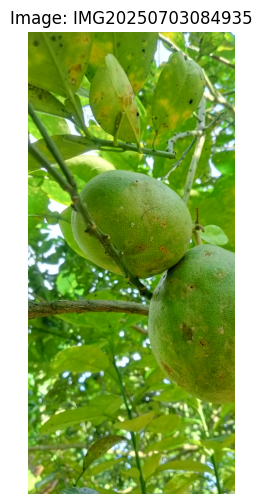


Available classes:
(1) Anthracnose
(2) Borer
(3) Canker
(4) Healthy
(5) Mites
(6) Multiple
(7) Skip
(x) Terminate
Terminating early by user request.

Successfully updated 1 class assignments.
Results saved to ../tracker/class_updates.csv


In [4]:
updater = ImageClassUpdater(
    excel_path="../tracker/stats.xlsx",
    csv_updates_path="../tracker/class_updates.csv", 
    image_folder="../images/raw",
    starting_row=120
)
result = updater.run()